In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F

In [14]:
dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root="./datasets/speechcommands",
    download=True,
    subset="testing"
)

Label: right, waveform shape: torch.Size([1, 16000]), sample_rate: 16000
x_real shape: torch.Size([1, 101, 10])


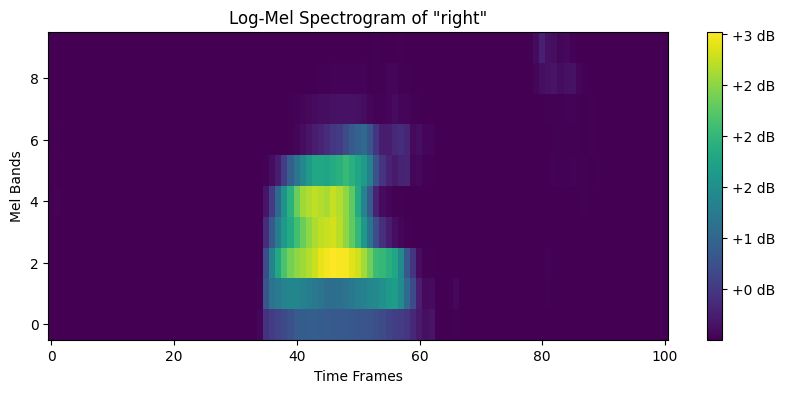

In [18]:
# Take the first example
waveform, sample_rate, label, *_ = dataset[4]  # waveform: (channels, samples)
waveform = waveform.mean(dim=0, keepdim=True)   # convert to mono

print(f"Label: {label}, waveform shape: {waveform.shape}, sample_rate: {sample_rate}")

# ------------------------------
# Convert to log-Mel spectrogram
# ------------------------------
n_mels = 10
n_fft = 400
hop_length = 160

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)(waveform)  # shape: (1, n_mels, time)

log_mel = torch.log1p(mel_spectrogram)  # log(1 + x) to stabilize

# ------------------------------
# Prepare input for CTC model
# ------------------------------
# transpose to (batch, time, features)
x_real = log_mel.transpose(1, 2)  # (1, time, n_mels)

print("x_real shape:", x_real.shape)

# plot the log-Mel spectrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.imshow(log_mel.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title(f'Log-Mel Spectrogram of "{label}"')
plt.xlabel('Time Frames')
plt.ylabel('Mel Bands')
plt.colorbar(format='%+2.0f dB')
plt.show()

# play the audio
import IPython.display as ipd
ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

In [20]:
class TinyCTCModel(nn.Module):
    
    def __init__(self, input_dim=10, hidden_dim=16, num_classes=5):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # x: (batch, time, input_dim)
        out, _ = self.rnn(x)
        logits = self.fc(out)  # (batch, time, num_classes)
        return logits.transpose(0,1)  # CTC expects (time, batch, num_classes)


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ------------------------------
# Tiny CTC model
# ------------------------------
class TinyCTCModel(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=16, num_classes=28):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        logits = self.fc(out)  # (batch, time, num_classes)
        return logits.transpose(0,1)  # (time, batch, num_classes)

# ------------------------------
# Custom differentiable CTC loss
# ------------------------------
def ctc_loss_custom(logits, target, blank=0):
    """
    logits: (time, batch, num_classes)
    target: (target_len,) for single batch
    """
    T, B, C = logits.size()
    assert B == 1, "Only single batch supported for simplicity"
    logits = logits[:,0,:]  # remove batch dimension -> (time, num_classes)
    log_probs = F.log_softmax(logits, dim=1)

    L = len(target)
    ext_target = torch.zeros(2*L+1, dtype=torch.long, device=logits.device)
    ext_target[1::2] = target
    S = len(ext_target)

    log_alpha = torch.full((T, S), -1e9, device=logits.device)
    log_alpha[0,0] = log_probs[0, blank]
    if S > 1:
        log_alpha[0,1] = log_probs[0, ext_target[1]]

    for t in range(1, T):
        for s in range(S):
            prev = [log_alpha[t-1,s]]
            if s > 0:
                prev.append(log_alpha[t-1,s-1])
            if s > 1 and ext_target[s] != blank and ext_target[s] != ext_target[s-2]:
                prev.append(log_alpha[t-1,s-2])
            log_alpha[t,s] = torch.logsumexp(torch.stack(prev), dim=0) + log_probs[t, ext_target[s]]

    return -torch.logsumexp(log_alpha[T-1, -2:], dim=0)

# ------------------------------
# Example setup
# ------------------------------
# Replace these with your actual speech features
x_real = x_real  # (1, time, n_mels)
label = label  # string label
char2idx = {c:i+1 for i,c in enumerate("abcdefghijklmnopqrstuvwxyz")}  # 0 = blank
num_classes = len(char2idx)+1

transcription = label.lower()
transcription = "".join([c for c in transcription if c in char2idx])
target = torch.tensor([char2idx[c] for c in transcription], dtype=torch.long)

# ------------------------------
# Model and optimizer
# ------------------------------
input_dim = x_real.shape[2]
model = TinyCTCModel(input_dim=input_dim, num_classes=num_classes)

x_real = x_real.clone().detach().requires_grad_(True)
logits_real = model(x_real)
loss_real = ctc_loss_custom(logits_real, target)
original_grads = torch.autograd.grad(loss_real, logits_real, create_graph=False)[0]

x_prime = torch.randn_like(x_real, requires_grad=True)
optimizer = optim.Adam([x_prime], lr=0.1)

# ------------------------------
# Gradient inversion loop
# ------------------------------
num_steps = 200
for step in range(num_steps):
    optimizer.zero_grad()
    logits_prime = model(x_prime)
    loss_prime = ctc_loss_custom(logits_prime, target)
    grads_prime = torch.autograd.grad(loss_prime, logits_prime, create_graph=True)[0]

    grad_loss = ((grads_prime - original_grads)**2).sum()
    grad_loss.backward()
    optimizer.step()

    x_prime.data.clamp_(x_real.min().item(), x_real.max().item())

    if step % 20 == 0:
        print(f"Step {step}, grad_loss={grad_loss.item():.4f}")

print("Gradient inversion finished.")


Step 0, grad_loss=7.0336
Step 20, grad_loss=0.4591
Step 40, grad_loss=0.1850
Step 60, grad_loss=0.1057
Step 80, grad_loss=0.0858
Step 100, grad_loss=0.0731
Step 120, grad_loss=0.0648
Step 140, grad_loss=0.0586
Step 160, grad_loss=0.0533
Step 180, grad_loss=0.0484
Gradient inversion finished.


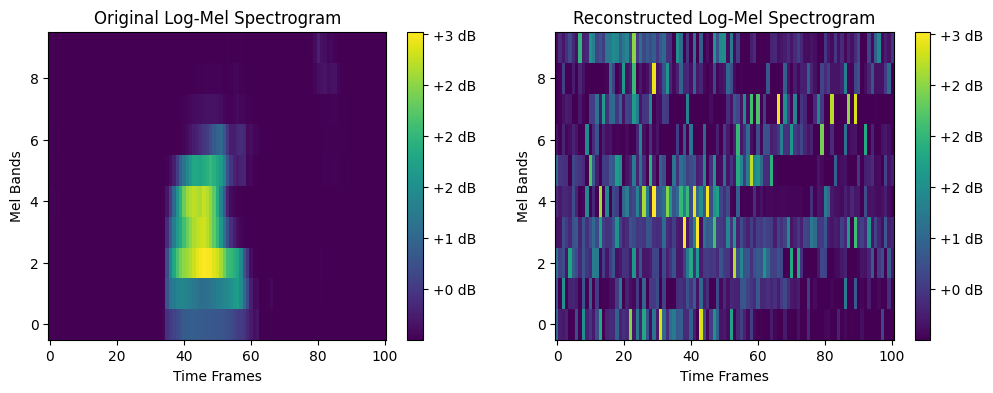

In [23]:
# plot the original, reconstructed log-Mel spectrogram next to each other
log_mel_prime = x_prime.detach().squeeze().transpose(0,1)  # (n_mels, time)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(log_mel.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('Original Log-Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Bands')
plt.colorbar(format='%+2.0f dB')
plt.subplot(1, 2, 2)
plt.imshow(log_mel_prime.numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('Reconstructed Log-Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Bands')
plt.colorbar(format='%+2.0f dB')
plt.show()


## Jax

In [9]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit
import optax

# ------------------------------
# Tiny linear-RNN model
# ------------------------------
def init_model_params(rng, input_dim, hidden_dim, num_classes):
    params = {
        "Wx": jax.random.normal(rng, (input_dim, hidden_dim)) * 0.1,
        "Wh": jax.random.normal(rng, (hidden_dim, hidden_dim)) * 0.1,
        "b_h": jnp.zeros(hidden_dim),
        "W_out": jax.random.normal(rng, (hidden_dim, num_classes)) * 0.1,
        "b_out": jnp.zeros(num_classes),
    }
    return params

def model(params, x):
    # x: (time, input_dim)
    h = jnp.zeros(params["Wh"].shape[0])
    outputs = []
    for t in range(x.shape[0]):
        h = jnp.tanh(x[t] @ params["Wx"] + h @ params["Wh"] + params["b_h"])
        out = h @ params["W_out"] + params["b_out"]
        outputs.append(out)
    return jnp.stack(outputs)  # (time, num_classes)

# ------------------------------
# Simple CTC-like loss (logsumexp forward)
# ------------------------------
def ctc_loss(logits, target, blank=0):
    T, C = logits.shape
    L = len(target)
    target_ext = jnp.zeros(2*L+1, dtype=int)
    target_ext = target_ext.at[1::2].set(target)
    S = len(target_ext)
    
    log_alpha = -jnp.inf * jnp.ones((T, S))
    log_alpha = log_alpha.at[0,0].set(logits[0, blank])
    log_alpha = log_alpha.at[0,1].set(logits[0, target_ext[1]])
    
    def step(log_alpha_prev, t):
        log_alpha_t = -jnp.inf * jnp.ones(S)
        for s in range(S):
            a = [log_alpha_prev[s]]
            a = a + ([log_alpha_prev[s-1]] if s > 0 else [])
            cond = (s > 1) & (target_ext[s] != blank) & (target_ext[s] != target_ext[s-2])
            a = a + ([log_alpha_prev[s-2]] if cond else [])
            log_alpha_t = log_alpha_t.at[s].set(jax.scipy.special.logsumexp(jnp.array(a)) + logits[t, target_ext[s]])
        return log_alpha_t, log_alpha_t

    _, log_alpha_all = jax.lax.scan(step, log_alpha[0], jnp.arange(1, T))
    log_probs = jax.scipy.special.logsumexp(log_alpha_all[-1, -2:])
    return -log_probs

# ------------------------------
# Dummy SpeechCommands features
# ------------------------------
rng = jax.random.PRNGKey(0)
T, input_dim = 8, 10
num_classes = 5
x_real = jax.random.normal(rng, (T, input_dim))
target = jnp.array([1,2,3], dtype=int)

params = init_model_params(rng, input_dim, hidden_dim=16, num_classes=num_classes)

# ------------------------------
# Original gradient w.r.t x_real
# ------------------------------
loss_fn = lambda x: ctc_loss(model(params, x), target)
original_grads = grad(loss_fn)(x_real)

# ------------------------------
# Dummy input and optimizer
# ------------------------------
x_prime = jax.random.normal(rng, (T, input_dim))
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(x_prime)

# ------------------------------
# Gradient inversion step (safe JIT)
# ------------------------------
@jit
def step(x, opt_state, original_grads):
    def grad_match_loss(xp):
        grads_prime = grad(loss_fn)(xp)
        return jnp.sum((grads_prime - original_grads)**2)
    
    loss_val, grad_x = value_and_grad(grad_match_loss)(x)
    updates, opt_state_new = optimizer.update(grad_x, opt_state)
    x_new = optax.apply_updates(x, updates)
    
    # clamp in a JAX-safe way
    x_new = jnp.clip(x_new, x_real.min(), x_real.max())
    return x_new, opt_state_new, loss_val

# ------------------------------
# Run inversion
# ------------------------------
for i in range(200):
    x_prime, opt_state, loss_val = step(x_prime, opt_state, original_grads)
    if i % 20 == 0:
        print(f"Step {i}, grad_loss={loss_val:.4f}")

print("Gradient inversion finished safely in JAX.")


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function step at /tmp/ipykernel_77596/2933833525.py:43 for scan. This value became a tracer due to JAX operations on these lines:

  operation a[35m:f32[7][39m = broadcast_in_dim[broadcast_dimensions=() shape=(7,) sharding=None] 1.0:f32[]
    from line /tmp/ipykernel_77596/2933833525.py:44:33 (ctc_loss.<locals>.step)

  operation a[35m:f32[7][39m = mul -inf:f32[] b
    from line /tmp/ipykernel_77596/2933833525.py:44:22 (ctc_loss.<locals>.step)

  operation a[35m:i32[1][39m = slice[limit_indices=(1,) start_indices=(0,) strides=None] b
    from line /tmp/ipykernel_77596/2933833525.py:48:30 (ctc_loss.<locals>.step)

  operation a[35m:bool[][39m = ne b 0:i32[]
    from line /tmp/ipykernel_77596/2933833525.py:48:30 (ctc_loss.<locals>.step)

  operation a[35m:bool[][39m = and False:bool[] b
    from line /tmp/ipykernel_77596/2933833525.py:48:19 (ctc_loss.<locals>.step)

(Additional originating lines are not shown.)
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

# Pytest

In [33]:
def test_ctc_random():
    torch.manual_seed(0)

    T = 8          # time steps
    num_classes = 5
    batch_size = 1

    # Random logits
    logits = torch.randn(T, batch_size, num_classes)

    # Random target
    target_len = 3
    target = torch.randint(1, num_classes, (target_len,), dtype=torch.long)

    input_lengths = torch.tensor([T], dtype=torch.long)
    target_lengths = torch.tensor([target_len], dtype=torch.long)

    # PyTorch built-in CTC
    ctc_loss_torch = nn.CTCLoss(blank=0, zero_infinity=True)
    log_probs = F.log_softmax(logits, dim=2)
    loss_torch = ctc_loss_torch(log_probs, target.unsqueeze(0), input_lengths, target_lengths)

    # Custom CTC
    loss_custom = ctc_loss_custom(logits, target)

    print("Torch CTC loss: ", loss_torch.item())
    print("Custom CTC loss:", loss_custom.item())

    # Assert they are close
    assert torch.isclose(loss_torch, loss_custom, atol=1e-4), \
        f"Custom CTC {loss_custom.item()} != Torch CTC {loss_torch.item()}"
    print("Test passed: Custom CTC matches PyTorch CTC.")

In [34]:
test_ctc_random()


Torch CTC loss:  1.9264191389083862
Custom CTC loss: 5.779257297515869


AssertionError: Custom CTC 5.779257297515869 != Torch CTC 1.9264191389083862

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------
# Custom CTC (single-batch)
# ------------------------------
def ctc_loss_custom(logits, target, blank=0):
    """
    logits: (time, batch, num_classes)
    target: (target_len,)
    """
    T, B, C = logits.size()
    assert B == 1, "Only single batch supported"
    logits = logits[:,0,:]  # remove batch dim
    log_probs = F.log_softmax(logits, dim=1)

    L = len(target)
    ext_target = torch.zeros(2*L+1, dtype=torch.long)
    ext_target[1::2] = target
    S = len(ext_target)

    log_alpha = torch.full((T, S), -1e9)
    log_alpha[0,0] = log_probs[0, blank]
    if S > 1:
        log_alpha[0,1] = log_probs[0, ext_target[1]]

    for t in range(1, T):
        for s in range(S):
            prev = [log_alpha[t-1,s]]
            if s > 0:
                prev.append(log_alpha[t-1,s-1])
            if s > 1 and ext_target[s] != blank and ext_target[s] != ext_target[s-2]:
                prev.append(log_alpha[t-1,s-2])
            log_alpha[t,s] = torch.logsumexp(torch.stack(prev), dim=0) + log_probs[t, ext_target[s]]

    return -torch.logsumexp(log_alpha[T-1, -2:], dim=0)


# ------------------------------
# Test function
# ------------------------------
def test_ctc_random():
    torch.manual_seed(0)

    # Time steps must be >= 2*target_len+1 for proper CTC
    target_len = 3
    T = 2*target_len + 3  # ensures feasible alignment
    num_classes = 5
    batch_size = 1

    # Random logits with small variance for numerical stability
    logits = torch.randn(T, batch_size, num_classes) * 0.1

    # Random target
    target = torch.randint(1, num_classes, (target_len,), dtype=torch.long)

    input_lengths = torch.tensor([T], dtype=torch.long)
    target_lengths = torch.tensor([target_len], dtype=torch.long)

    # --- PyTorch CTC ---
    ctc_loss_torch = nn.CTCLoss(blank=0, zero_infinity=True)
    log_probs = F.log_softmax(logits, dim=2)
    loss_torch = ctc_loss_torch(log_probs, target.unsqueeze(0), input_lengths, target_lengths)

    # --- Custom CTC ---
    loss_custom = ctc_loss_custom(logits, target)

    print("Torch CTC loss: ", loss_torch.item())
    print("Custom CTC loss:", loss_custom.item())

    # Assert they are close
    assert torch.isclose(loss_torch, loss_custom, atol=1e-4), \
        f"Custom CTC {loss_custom.item()} != Torch CTC {loss_torch.item()}"
    print("Test passed: Custom CTC matches PyTorch CTC.")


test_ctc_random()


Torch CTC loss:  2.46632981300354
Custom CTC loss: 7.398989677429199


AssertionError: Custom CTC 7.398989677429199 != Torch CTC 2.46632981300354